## still under construction

In [1]:
import os, shutil, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import helperfunctionsfMRI as fh
import MRIhelperfunctions as h

In [61]:
importlib.reload(fh)
import helperfunctionsfMRI as fh
importlib.reload(h)
import MRIhelperfunctions as h

# Settings

In [62]:
paradigm = {}
folders = {}
averaging = {}

paradigm['TR'] = 1 # in seconds

paradigm['initial_cutoff'] = 30 # number of volumes to remove (in absence of dummy scans).

blurFWHM = 0.3 # In [mm]. Rule-of-thumb: 1.5x the voxel resolution.

highpass = 180 # period [s]. Any signal slower than this will be removed. Should be at least 2x inter-stim. interval


# --- For averaging of blocks:

averaging['baseline'] = 20 # baseline to consider before each block

averaging['time'] = 60 # how many seconds to display after end of stim_block


#======================================================================
folders['animal'] = '/home/felix/Desktop/examplescan'
folders['scanNumber'] = '10'
#======================================================================


# --- EPI Template for coregistration ---
folders['template'] = '/home/felix/Desktop/examplescan/template/template.nii'


# --- Optional: ROI file:
folders['rois'] = '/home/felix/Desktop/examplescan/template/ROIs.nii'



# --- Define the stimulation paradigm (all units in seconds):
paradigm['baseline'] = 180
paradigm['stim_duration'] = 20 
paradigm['Nblocks'] = 10
paradigm['ISI'] = 60  # Inter-stimulus interval (on+off period)
paradigm['frequency'] = 4 


paradigm['stim_times'], paradigm['stim_onsets'], paradigm['stim_times_all'], paradigm['singleblock'] = fh.CreateStimParadigm(paradigm)

stimulus times: [180, 240, 300, 360, 420, 480, 540, 600, 660, 720]


In [63]:
# this creates also the 'analysis' and 'scan' folders
folders = h.check_and_convert_single(folders)

# Data Preprocessing

In [5]:
folders['cut'] = fh.initial_cutoff(folders['raw'], paradigm['initial_cutoff'])

In [6]:
# takes several minutes
folders['coreg'] = h.coreg_epi_to_template(folders['template'], folders['cut'])

3dTcat -overwrite -prefix /home/felix/Desktop/examplescan/analysis/10/single_timepoint.nii /home/felix/Desktop/examplescan/analysis/10/data_cut.nii'[0]'
python2.7 /home/felix/abin/align_epi_anat.py -dset2to1 -dset1 /home/felix/Desktop/examplescan/template/template.nii -dset2 /home/felix/Desktop/examplescan/analysis/10/single_timepoint.nii -child_dset2 /home/felix/Desktop/examplescan/analysis/10/data_cut.nii -dset1_strip None -dset2_strip None -overwrite -big_move -volreg on -volreg_method 3dvolreg -volreg_opts '-Fourier -zpad 1 -dfile dfile.1D' -Allineate_opts '-maxrot 10 -maxshf 3 -conv 0.005 -twofirst -twoblur 0.8 -source_automask+2 -final wsinc5' -tshift on -tshift_opts '-tzero 0 -quintic' -dset2_base 0 -volreg_base 0 -suffix .volreg -cost ls


### Check for motion

In [7]:
frame = pd.read_csv(os.path.join(folders['scan'],'dfile.1D'), sep=r'\s{2,}', engine='python')

%matplotlib qt
# frame.plot(subplots=True, layout=(9,1))
frame.iloc[:,1:7].plot(subplots=True, layout=(6,1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d82fc5e10>],
      dtype=object)

High-pass filter, smoothing

In [11]:
folders['cleaned'] = fh.filter_blur(folders['coreg'], highpass, blurFWHM)

# GLM Analysis

In [12]:
fh.Deconvolve(folders['cleaned'],paradigm)

3dDeconvolve -input /home/felix/Desktop/examplescan/analysis/10/CleanedData.nii -polort 0 -nodmbase -overwrite -num_stimts 1 -stim_times 1 '1D: 720 780 840 900 960 1020 1080 1140 1200 1260' 'SPMG3(40)' -stim_times_subtract 30 -stim_label 1 stim -iresp 1 HRF_SPM_el -fout -tout -x1D XSPM.xmat.1D -xjpeg XSPM.jpg -fitts fittsSPM_ -errts errtsSPM -bucket statsSPM_ -cbucket regcoeffsSPM


# ROI Analysis

Can be run separately on previously analyzed datasets, but first execute all cells under "Settings" above

In [4]:
folders['cleaned'] = fh.find_cleaned_data(folders)
folders['roidata'] = h.extract_roi(folders['cleaned'],folders['rois'])

roi_df = pd.read_csv(folders['roidata'], sep='\t')
del roi_df['File'], roi_df['Sub-brick']

Plotting whole time course

In [59]:
%matplotlib qt

plt.figure()
for rois in roi_df.columns:
    plt.plot(roi_df[rois])
_ = [plt.axvline(_p, alpha=0.05, color='red') for _p in paradigm['stim_times_all']]
_ = plt.legend(roi_df.columns)

Plotting averages across stimulus blocks

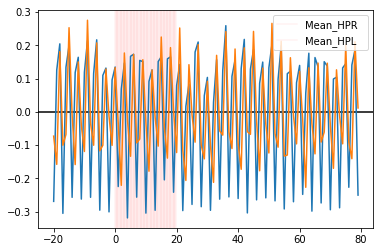

In [66]:
%matplotlib inline

roimeans = fh.averageblocks(roi_df, paradigm, averaging)

plt.figure()
_ = [plt.axvline(_p, alpha=0.05, color='red') for _p in paradigm['singleblock']]
plt.axhline(0,color='k')
plt.plot(roimeans)
_ = plt.legend(roi_df.columns)
